In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib.colors import Normalize

In [2]:
def check_stability(D, dt, dx):
    """
    Check the stability condition for the diffusion equation and raise an error if unstable.

    :param D: The diffusion coefficient.
    :param dt: The time step.
    :param dx: The space step.
    """
    if (4 * D * dt) / (dx**2) > 1:
        raise ValueError("The given parameters will result in an unstable solution. "
                         "Stability condition violated: (4Ddt/dx^2) should be <= 1. "
                         "Please use a smaller time step or a larger space step.")

    
def generate_time_steps(T, dt):
    return np.arange(0, T+dt, dt)

def init_concentration_matrix(x,y,t):
    return np.zeros((x,y,t), dtype=float)

def init_concentration_matrix_2d(x,y):
    return np.zeros((x,y), dtype=float)


## 1.1 Vibrating String

In [3]:
# Parameters for all string simulations

c = 1 #wave speed
L = 1 #length of string
T = 1 #total time to simulate
dt = 0.001 #time step
N = 1000 #number of spatial divisions
dx = L/N #space step

# For plots
y = np.arange(0, L+dx, dx)

#### A  
Discretize the wave equation, and write it in a form suitable for implementing in a computer program. Assume that the boundaries are fixed, Ψ(res = 0,t) = 0, Ψ(x = L,t) = 0. L is the length of the string. Take L = 1 for simplicity. Divide the string in N intervals, so that the interval length is ∆x = L/N. Also consider the boundary cases.

#### B  

Function to simulate the vibrating string using euler step for the first time step and finite difference method(stepping method) for further evolution.\
**Boundary conditions**: $\psi(x = 0, t)$ = 0 and $\psi(x = L,t)$ = 0.

In [74]:
def simulate_vibrating_string(c, T, dt, dx, x_0):
    """
    Simulate the vibrating string with the given parameters.
    param x_0: The initial displacement of the string.
    param c: The wave speed.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.    
    """ 
    time_steps = np.arange(0, T+dt, dt)
    res = np.zeros((len(x_0), len(time_steps)), dtype=float)
    dpsi_dt = 0 # Initial condition
    
    res[:,0] = x_0
    res[:,1] = res[:,0] + dpsi_dt*dt

    # stepping method to find the next time steps.
    for j in range(2, len(time_steps)):
        res[1:-1, j] = 2*res[1:-1, j-1] - res[1:-1, j-2] + (c**2 * (dt/dx)**2 * (res[2:, j-1] + res[0:-2, j-1] - 2*res[1:-1,j-1]))

    return res
    

In [77]:
# define the initial conditions for the wave equation and run the simulation
psi0 = np.sin(2 * np.pi * y)
psi1 = np.sin(5 * np.pi * y)
psi2 = np.array([np.sin(5 * np.pi * x) if 1/5 < x < 2/5 else 0 for x in y])

res0 = simulate_vibrating_string(c, T, dt, dx, psi0)
res1 = simulate_vibrating_string(c, T, dt, dx, psi1)
res2 = simulate_vibrating_string(c, T, dt, dx, psi2)

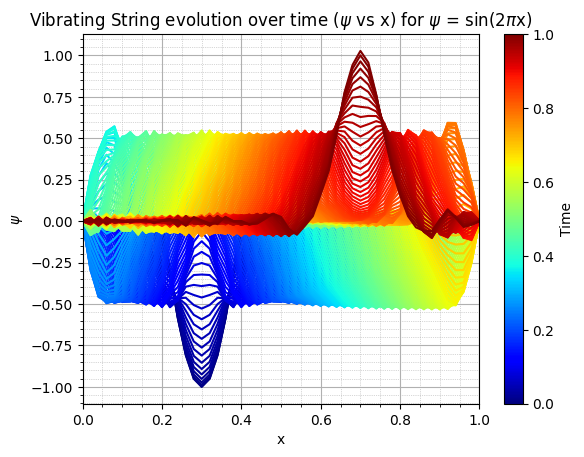

In [81]:
fig, ax = plt.subplots()
norm = Normalize(vmin=0, vmax=T)  # Normalize time for colormap
for i,t in enumerate(np.arange(0, T+dt, dt)):
    if i % 50 == 0: # plot every 20th time step
        ax.plot(y, res2[:,i], color=plt.cm.jet(norm(t)))
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi$')
ax.set_title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin({2}$\pi$x)')
ax.set_xlim(0, L)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5')

# Add colorbar
mappable = plt.cm.ScalarMappable(norm=norm, cmap='jet')
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label('Time')

plt.show()

#### C  
Animation

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi$')
ax.set_title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin(5$\pi$x)')
ax.grid(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5')

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    y = x[:, i]
    line.set_data(np.arange(0, L+dx, dx), y)
    return line,

ani = FuncAnimation(fig, animate, init_func=init, frames=len(np.arange(0, T+dt, dt)), interval=50, blit=True)

# To save the animation, uncomment the following line
ani.save('string_vibration.mp4', writer='ffmpeg')
#ani.save('string_vibration.gif', writer=PillowWriter(fps=20))


### 1.2 The Time Dependent Diffusion Equation

In [9]:
# Parameters for all diffusion simulations

c = 1 #concentration
L = 1 #length of domain (x and y)
T = 1 #total time to simulate
dt = 0.0001 #time step
N = 50 #number of spatial divisions
dx = L/N #space step
D = 1 #diffusion coefficient

# For plots
y = np.arange(0, L+dx, dx)

# Initial condition for simulations
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[-1, :] = 1

#### D  

Determine the equation to use at the boundaries of the domain. Clearly show the ranges of the indices of the grid. A figure is extremely helpful for figuring this out.
Write a program for the simulation of the two-dimensional time dependent diffusion equation discretized using the explicit finite difference formulation from eq. (7). You may want to write your data to file (e.g. after every iteration, of maybe after every 100 iterations) so that you can analyze the data later on, or plot it immediately.

#### F

Plot the results, show the 2D domain, with a color representing the concentration at each point. Make a plot of the state of the system at several times: t = {0, 0.001, 0.01, 0.1, and 1}.

In [15]:
def simulate_2D_diffusion(D, T, dt, dx, x_0):
    """
    Simulate the 2D diffusion with the given parameters, source at y=L, sink at y=0, and periodic boundary conditions at x=0 and x=L.
    param D: The diffusion coefficient.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.
    param x_0: The initial concentration.    
    """

    check_stability(D, dt, dx)
    time_steps = generate_time_steps(T, dt)
    res = init_concentration_matrix(len(x_0), len(x_0), len(time_steps)) # x[i,j,k] is the concentration at position y=i,x=j at time k.

    res[-1,:,:] = 1 # Set the boundary condition at y=L.
    res[0,:,:] = 0 # Set the boundary condition at y=0.
    res[:,:,0] = x_0 # Set the initial condition.
    
    # Assuming periodic boundary conditions at x=0 and x=L.
    for k in range(1, len(time_steps)):
        res[1:-1, :, k] = res[1:-1, :, k-1] + ((D * dt) / (dx**2)) * (np.roll(res[1:-1, :, k-1],-1,axis=1) + np.roll(res[1:-1, :, k-1],1,axis=1) + res[2:, :, k-1] + res[0:-2, :, k-1] - 4*res[1:-1, :, k-1])

    # for k in range(1, len(time_steps)):
    #     for i in range(1, x.shape[0] - 1):
    #         for j in range(x.shape[1]):
    #             jp = (j + 1) % x.shape[1]  # If at the end, wrap to the beginning
    #             jm = (j - 1) % x.shape[1]  # If at the beginning, wrap to the end
    #             x[i, j, k] = x[i, j, k-1] + ((D * dt) / (dx**2)) * (x[i+1, j, k-1] + x[i-1, j, k-1] + x[i, jp, k-1] + x[i, jm, k-1] - 4*x[i, j, k-1])
        
    return res


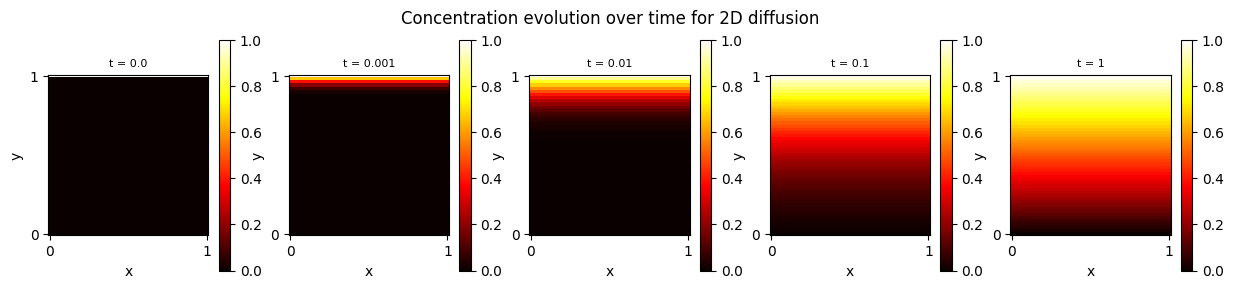

In [16]:
res = simulate_2D_diffusion(D, T, dt, dx, x_0)

fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15, 3))
for i,t in enumerate([0.0, 0.001, 0.01, 0.1, 1]):
    im = ax[i].imshow(res[:,:,int(t/dt)], cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=ax[i])
    #fig.colorbar(im, ax=ax[i], label='Concentration'
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, N], ['0', str(L)])
    ax[i].set_yticks([0, N], ['0', str(L)])
    ax[i].set_title('t = {}'.format(t), fontsize=8)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.show()


#### E  
Test the correctness of your simulation. Compare to the analytic solutions, plot c(y) for different times. 

In [17]:
def diffusion_2d_analytical(y, t, D, tolerance=1e-15, max_iterations=10000):
    """
    Calculate the series solution for the concentration c(y, t).
    param y: position of y coordinate.
    param t: time.
    param D: diffusion coefficient.
    param tolerance: convergence criterion for stopping the sum.
    param max_iterations: maximum number of iterations to avoid infinite loops.
    """
    sum = 0
    last_term = 0
    for i in range(max_iterations):
        term = erfc((1 - y + 2*i) / (2 * np.sqrt(D * t))) - erfc((1 + y + 2*i) / (2 * np.sqrt(D * t)))
        sum += term
        
        # Check for convergence
        if np.max(np.abs(abs(term - last_term))) < tolerance:
            break
        last_term = term

    return sum

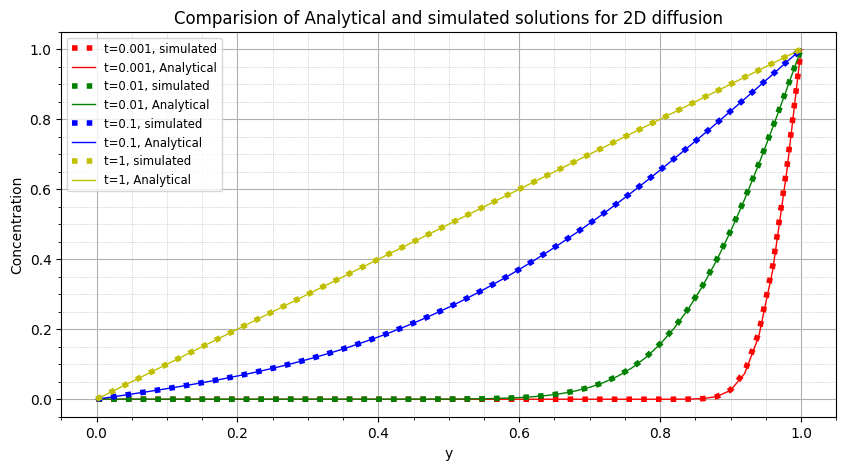

In [18]:
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'y']
for i,t in enumerate([0.001, 0.01, 0.1, 1]):
    color = colors[i]
    plt.plot(y, res[:,0,int(t/dt)], linestyle = 'dotted', label = f't={t}, simulated',color=color, linewidth=4)
    plt.plot(y, diffusion_2d_analytical(y, t, D), label = f't={t}, Analytical', color=color, linewidth=1)

plt.legend(fontsize='small')
plt.ylabel('Concentration')
plt.xlabel('y')
plt.title('Comparision of Analytical and simulated solutions for 2D diffusion')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### G  
Make an animated plot of the time dependent diffusion equation until equilibrium.

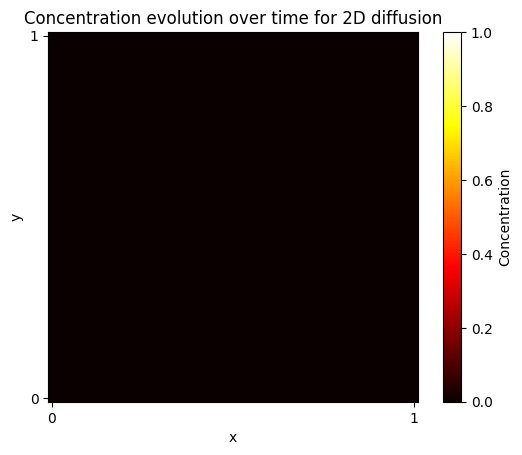

In [20]:
fig, ax = plt.subplots()
cax = ax.imshow(res[:, :, 0], cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([0, N], ['0', str(L)])
ax.set_yticks([0, N], ['0', str(L)])
ax.set_title('Concentration evolution over time for 2D diffusion')

# Initialization function for FuncAnimation
def init():
    cax.set_data(np.zeros((L, L)))
    return cax,

# Animation function that FuncAnimation will call
def animate(i):
    cax.set_data(res[:, :, i])
    return cax,

ani = FuncAnimation(fig, animate, frames=res.shape[2], init_func=init, blit=True, repeat=False)

# ani.save('diffusion.mp4', writer='ffmpeg')
#ani.save('diffusion.gif', writer='pillow', fps=30)

### 1.3 The Time Independent Diffusion Equation

### 1.4 The Jacobi Iteration

In [24]:
def simulate_2D_diffusion_jacobi(x_0, epsilon = 1e-5, max_iter = 20000, save_iter_interval = 10):
    """
    Simulate the 2D diffusion using the Jacobi iteration method with a stopping condition.
    
    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    :param max_iter: The maximum number of iterations.
    :param save_iter_interval: The interval at which to save the concentration matrix.
    """

    c_current = init_concentration_matrix_2d(len(x_0), len(x_0))
    c_current[:,:] = x_0 # Initial condition at t=0
    c_next = c_current.copy()
    
    saved_matrices = []
    deltas = []
    saved_matrices.append(c_current.copy())
    
    for k in range(1, max_iter+1):
        for i in range(1, c_current.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c_current.shape[1]):
                jp = (j + 1) % c_current.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c_current.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c_next[i, j] = 0.25 * (c_current[i+1, j] + c_current[i-1, j] +
                                    c_current[i, jp] + c_current[i, jm])

        delta = np.max(np.abs(c_next - c_current))
        if k % save_iter_interval == 0:  # Save iterations in intervals
            saved_matrices.append(c_next.copy())
            deltas.append(delta)
        
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break

        c_current[:, :] = c_next

    return saved_matrices, c_current, k, deltas

In [22]:
jacobi, cj, k, _ = simulate_2D_diffusion_jacobi(x_0)

Convergence reached at 4195 iterations


In [30]:
def plot_concentration_evolution(saved_matrices, figshape, figsize, iter_method, iter_range, save_iter_interval):    
    fig, ax = plt.subplots(nrows=figshape[0], ncols=figshape[1], figsize=figsize)

    for i, iter in enumerate(iter_range):
        im = ax[i].imshow(saved_matrices[int(iter/save_iter_interval)], cmap='hot', interpolation='nearest', origin='lower', extent=[0, L, 0, L])
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
        ax[i].set_xticks([0, L])
        ax[i].set_yticks([0, L])
        ax[i].set_title(f'iteration = {iter}', fontsize=10)

    fig.colorbar(im, ax=ax[-1], fraction=0.046, pad=0.04)

    fig.suptitle(f'Concentration at different iterations for {iter_method} Iteration method', fontsize=12)
    plt.tight_layout()
    plt.show()

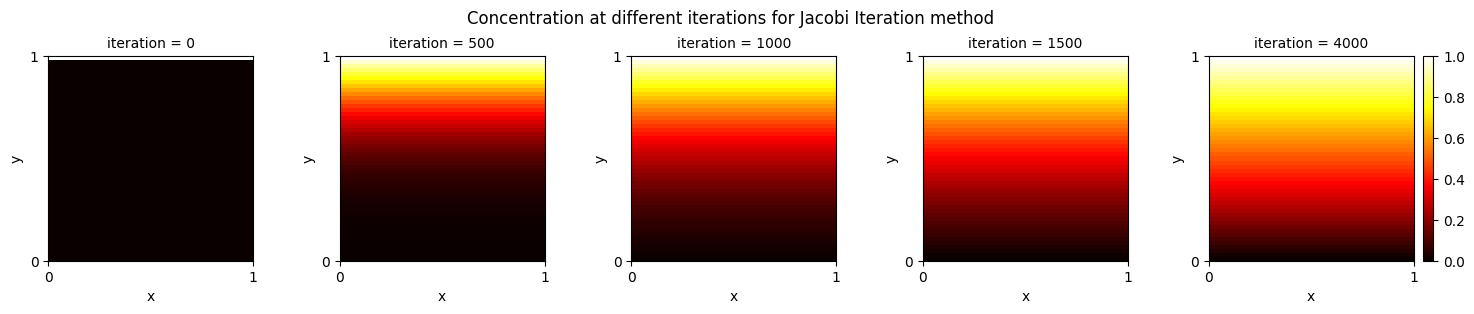

In [ ]:
figshape = (1, 5)
figsize = (15, 3)
iter_method = 'Jacobi'
iter_range = [0, 500, 1000, 1500, 4000]
save_iter_interval = 10
plot_concentration_evolution(jacobi, figshape, figsize, iter_method, iter_range, save_iter_interval)

### 1.5 The Gauss-Seidel Iteration

In [25]:
def simulate_2D_diffusion_gauss_seidel(x_0, epsilon = 1e-5, max_iter = 10000, save_iter_interval = 10):
    """
    Simulate the 2D diffusion using the Gauss-Seidel iteration method with a stopping condition.
 
    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    :param max_iter: The maximum number of iterations.
    :param save_iter_interval: The interval at which to save the concentration matrix.
    """
    c = init_concentration_matrix_2d(len(x_0), len(x_0))
    c[:,:] = x_0 # Initial condition at t=0
    
    saved_matrices = []
    deltas = []
    saved_matrices.append(c.copy())

    for k in range(1, max_iter+1):
        c_old = c.copy()
        # Perform Gauss-Seidel iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm])
        
        delta = np.max(np.abs(c - c_old))

        if k % save_iter_interval == 0:  # Save iterations in intervals
            saved_matrices.append(c.copy())
            deltas.append(delta)
        
        # Check for convergence 
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == max_iter:
            print(f"No convergence after max time steps iterations {max_iter}")
            break
    
    return saved_matrices, c, k, deltas

Convergence reached at 2462 iterations


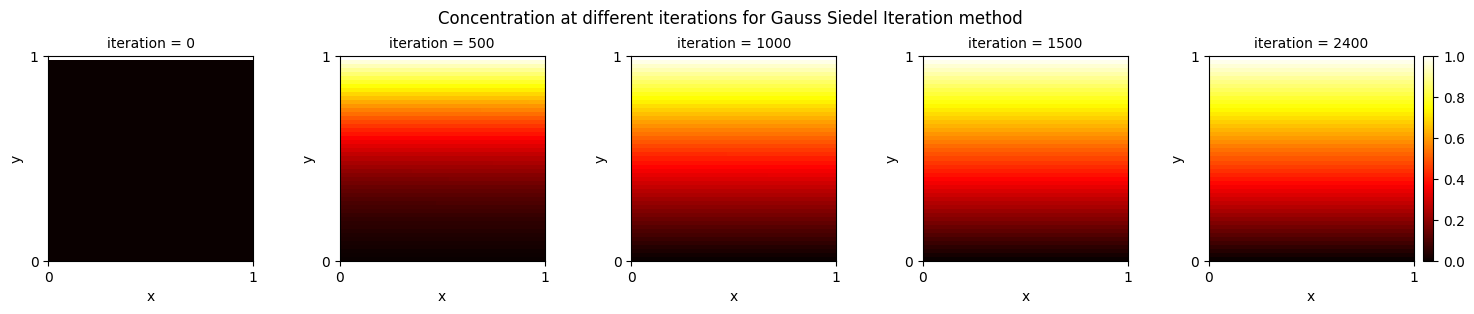

In [31]:
gauss, cg, k, _ = simulate_2D_diffusion_gauss_seidel(x_0)
figshape = (1, 5)
figsize = (15, 3)
iter_method = 'Gauss Siedel'
iter_range = [0, 500, 1000, 1500, 2400]
save_iter_interval = 10
plot_concentration_evolution(gauss, figshape, figsize, iter_method, iter_range, save_iter_interval)


### 1.6 Successive Over Relaxation

In [26]:
def simulate_2D_diffusion_SOR(x_0, epsilon = 1e-5, omega=1.85, max_iter = 10000, save_iter_interval = 10):
    """
    Simulate the 2D diffusion using the Successive Over Relaxation (SOR) method with a stopping condition.

    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    :param omega: The relaxation parameter for SOR.
    :param max_iter: The maximum number of iterations.
    :param save_iter_interval: The interval at which to save the concentration matrix.
    """
    c = init_concentration_matrix_2d(len(x_0), len(x_0))
    c[:,:] = x_0 # Initial condition at t=0
    
    saved_matrices = []
    deltas = []
    saved_matrices.append(c.copy())

    for k in range(1, max_iter+1):
        c_old = c.copy()
        # Perform SOR iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]
   
        delta = np.max(np.abs(c - c_old))

        if k % save_iter_interval == 0:  # Save iterations in intervals
            saved_matrices.append(c.copy())
            deltas.append(delta)

        # Check for convergence
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break
    
    return saved_matrices, c, k, deltas

Convergence reached at 404 iterations


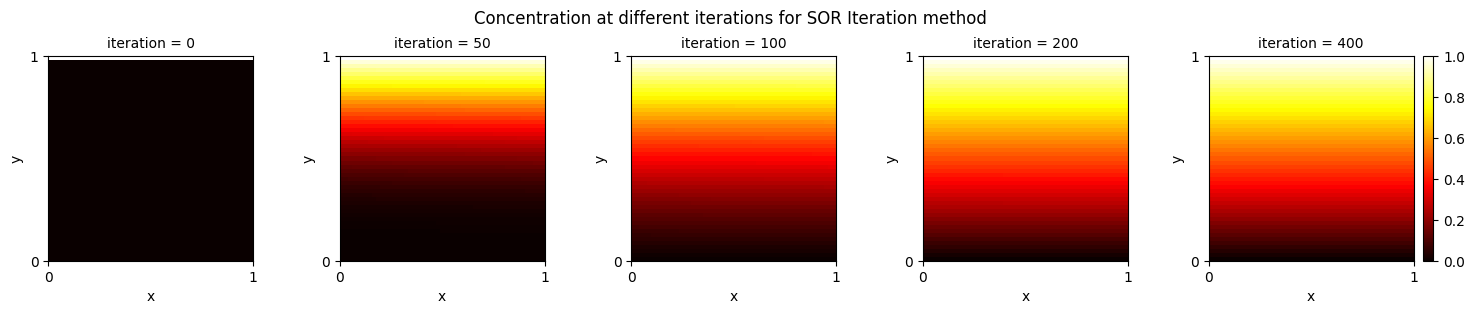

In [32]:
sor1, cs1, k, _ = simulate_2D_diffusion_SOR(x_0, omega=1.80)
figshape = (1, 5)
figsize = (15, 3)
iter_method = 'SOR'
iter_range = [0, 50, 100, 200, 400]
save_iter_interval = 10
plot_concentration_evolution(sor1, figshape, figsize, iter_method, iter_range, save_iter_interval)

#### H  
Implement the Jacobi iteration, the Gauss-Seidel method and SOR. Try N = 50. Test the methods by comparing the result to the analytical result in eq. (5), i.e. the linear dependence of the concentration on y.

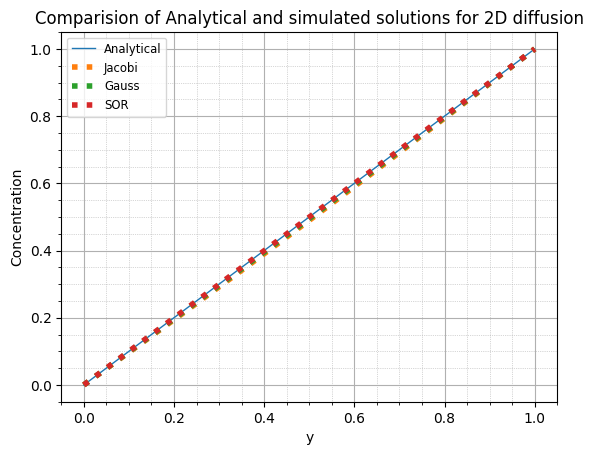

In [42]:
ca = diffusion_2d_analytical(y, 10, D)

plt.figure()
plt.plot(y, ca, label = 'Analytical', linewidth=1)
plt.plot(y, cj[:, 1], linestyle='dotted', linewidth=4, label='Jacobi')
plt.plot(y, cg[:, 1], linestyle='dotted', linewidth=4, label='Gauss')
plt.plot(y, cs1[:, 1], linestyle='dotted', linewidth=4, label='SOR')

plt.legend(fontsize='small')
plt.ylabel('Concentration')
plt.xlabel('y')
plt.title('Comparision of Analytical and simulated solutions for 2D diffusion')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### I
Show how the convergence measure δ in eq. (14) depends on the number of iterations k for each of the methods. A log-lin plot may be suitable. For SOR, choose a few representative values for ω.

#### Convergence vs iterations

Convergence reached at 4195 iterations
Convergence reached at 2462 iterations
Convergence reached at 404 iterations
Convergence reached at 307 iterations
Convergence reached at 206 iterations


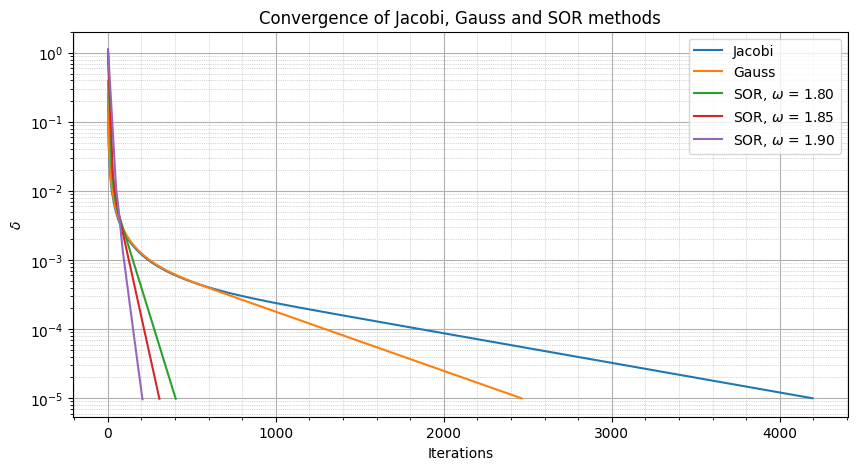

In [ ]:
_, _, kj, deltas_jacobi = simulate_2D_diffusion_jacobi(x_0, save_iter_interval=1)
_, _, kg, deltas_gauss = simulate_2D_diffusion_gauss_seidel(x_0, save_iter_interval=1)
_, _, ks_180, deltas_sor_180 = simulate_2D_diffusion_SOR(x_0, omega=1.80, save_iter_interval=1)
_, _, ks_185, deltas_sor_185 = simulate_2D_diffusion_SOR(x_0, omega=1.85, save_iter_interval=1) 
_, _, ks_190, deltas_sor_190 = simulate_2D_diffusion_SOR(x_0, omega=1.90, save_iter_interval=1)    
# _, _, ks_195, deltas_sor_195 = simulate_2D_diffusion_SOR(x_0, omega=1.95, save_iter_interval=1) 

plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(1,kj+1,1), deltas_jacobi, label='Jacobi')
plt.semilogy(np.arange(1,kg+1,1), deltas_gauss, label='Gauss')
plt.semilogy(np.arange(1,ks_180+1,1), deltas_sor_180, label=r'SOR, $\omega$ = 1.80')
plt.semilogy(np.arange(1,ks_185+1,1), deltas_sor_185, label=r'SOR, $\omega$ = 1.85')
plt.semilogy(np.arange(1,ks_190+1,1), deltas_sor_190, label=r'SOR, $\omega$ = 1.90')
#plt.semilogy(np.arange(1,ks_195+1,1), deltas_sor_195, label=r'SOR, $\omega$ = 1.95')

plt.xlabel('Iterations')
plt.ylabel(r'$\delta$')
plt.title('Convergence of Jacobi, Gauss and SOR methods')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()


#### Iterations to convergence vs Epsilon

In [ ]:
jacobi_iters = []
gauss_iters = []
sor_iters_80 = []
sor_iters_90 = []
sor_iters_85 = []

errors_jacobi = []
errors_gauss = []
errors_sor_90 = []

#p_values = np.linspace(3, 9, num=6)
p_values = np.arange(3, 10, 1)
for p in p_values:
    eps = 10.0**(-p)

    _, cj, jacobi_k,_ = simulate_2D_diffusion_jacobi(x_0, epsilon=eps)
    jacobi_iters.append(jacobi_k)
    error_jacobi = np.max(np.abs(ca - cj[:, 1]))
    errors_jacobi.append(error_jacobi)

    _, cg, gauss_k,_ = simulate_2D_diffusion_gauss_seidel(x_0, epsilon=eps)
    gauss_iters.append(gauss_k)
    error_gauss = np.max(np.abs(ca - cg[:, 1]))
    errors_gauss.append(error_gauss)
    
    _, _, sor_k1,_ = simulate_2D_diffusion_SOR(x_0, omega=1.80, epsilon=eps)
    sor_iters_80.append(sor_k1)

    _, _, sor_k2,_ = simulate_2D_diffusion_SOR(x_0, omega=1.85, epsilon=eps)
    sor_iters_85.append(sor_k2)

    _, cs, sor_k3,_ = simulate_2D_diffusion_SOR(x_0, omega=1.90, epsilon=eps)
    sor_iters_90.append(sor_k3)
    error_sor_90 = np.max(np.abs(ca - cs[:, 1]))
    errors_sor_90.append(error_sor_90)

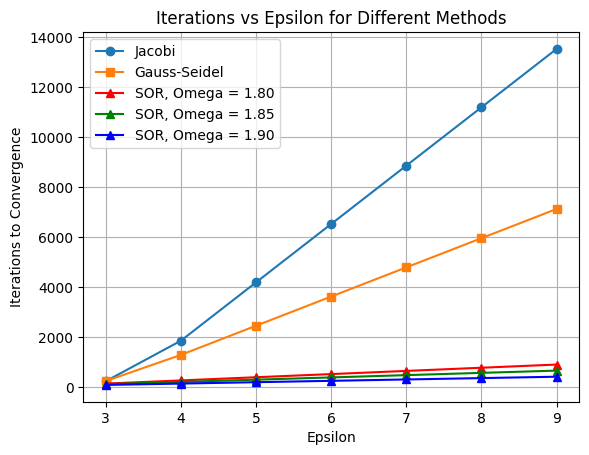

In [ ]:
epsilons = [10.0**(-p) for p in p_values]
plt.figure()
# plt.semilogx(epsilons, jacobi_iters, marker='o', label='Jacobi')
# plt.semilogx(epsilons, gauss_iters, marker='s', label='Gauss-Seidel')
# plt.semilogx(epsilons, sor_iters_80, marker='^', label='SOR, Omega = 1.80', color='r')
# plt.semilogx(epsilons, sor_iters_85, marker='^', label='SOR, Omega = 1.85', color='g')
# plt.semilogx(epsilons, sor_iters_90, marker='^', label='SOR, Omega = 1.90', color='b')

plt.plot(p_values, jacobi_iters, marker='o', label='Jacobi')
plt.plot(p_values, gauss_iters, marker='s', label='Gauss-Seidel')
plt.plot(p_values, sor_iters_80, marker='^', label='SOR, Omega = 1.80', color='r')
plt.plot(p_values, sor_iters_85, marker='^', label='SOR, Omega = 1.85', color='g')
plt.plot(p_values, sor_iters_90, marker='^', label='SOR, Omega = 1.90', color='b')

plt.xlabel('Epsilon')
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Epsilon for Different Methods')
plt.legend()
plt.grid(True)
plt.show()

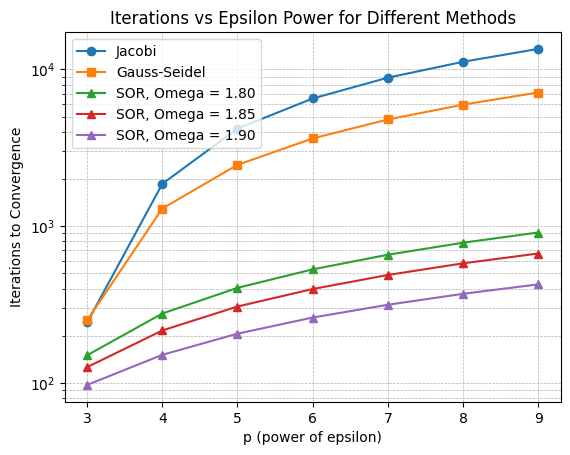

In [ ]:
plt.figure()
plt.semilogy(p_values, jacobi_iters, marker='o', label='Jacobi')
plt.semilogy(p_values, gauss_iters, marker='s', label='Gauss-Seidel')
plt.semilogy(p_values, sor_iters_80, marker='^', label='SOR, Omega = 1.80')
plt.semilogy(p_values, sor_iters_85, marker='^', label='SOR, Omega = 1.85')
plt.semilogy(p_values, sor_iters_90, marker='^', label='SOR, Omega = 1.90')

plt.xlabel('p (power of epsilon)')
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Epsilon Power for Different Methods')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


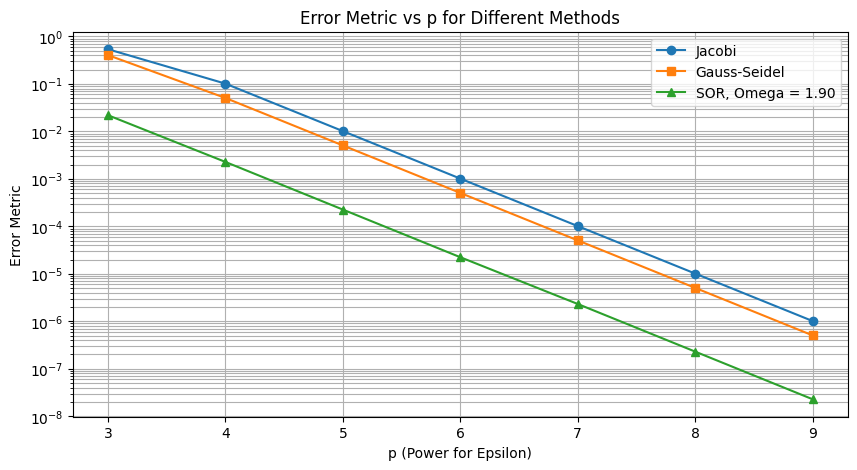

In [ ]:
# Create a log-log plot of error metric vs p for each method
plt.figure(figsize=(10, 5))
plt.semilogy(p_values, errors_jacobi, marker='o', label='Jacobi')
plt.semilogy(p_values, errors_gauss, marker='s', label='Gauss-Seidel')
plt.semilogy(p_values, errors_sor_90, marker='^', label='SOR, Omega = 1.90')


plt.xlabel('p (Power for Epsilon)')
plt.ylabel('Error Metric')
plt.title('Error Metric vs p for Different Methods')
plt.legend()
plt.grid(True, which='both')
plt.show()


#### J
In the SOR method, find the optimal ω. How does it depend on N?.


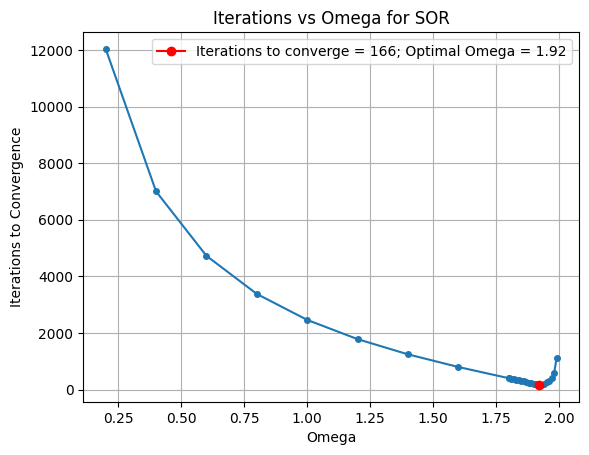

In [67]:
sor_k = []
omegas = np.append(np.arange(0.2,2,0.2),np.arange(1.80,2.0,0.01))

for o in omegas:
    _, _, k,_ = simulate_2D_diffusion_SOR(x_0, omega=o, max_iter=20000)
    sor_k.append(k)

min_iterations = min(sor_k)
min_omega = omegas[sor_k.index(min_iterations)]

plt.figure()
plt.plot(omegas, sor_k, marker = 'o', markersize=4)
plt.plot(min_omega, min_iterations, marker='o', markersize=6, color='r', label=f'Iterations to converge = {min_iterations}; Optimal Omega = {min_omega:.2f}')
plt.legend(loc='upper right')
plt.xlabel('Omega')
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Omega for SOR')
plt.legend()
plt.grid(True)
plt.show()

Convergence reached at 595 iterations
Convergence reached at 360 iterations
Convergence reached at 112 iterations
Convergence reached at 1863 iterations
Convergence reached at 1296 iterations
Convergence reached at 130 iterations
Convergence reached at 2420 iterations
Convergence reached at 2359 iterations
Convergence reached at 385 iterations
Convergence reached at 2420 iterations
Convergence reached at 2445 iterations
Convergence reached at 702 iterations
Convergence reached at 2420 iterations
Convergence reached at 2445 iterations
Convergence reached at 1041 iterations


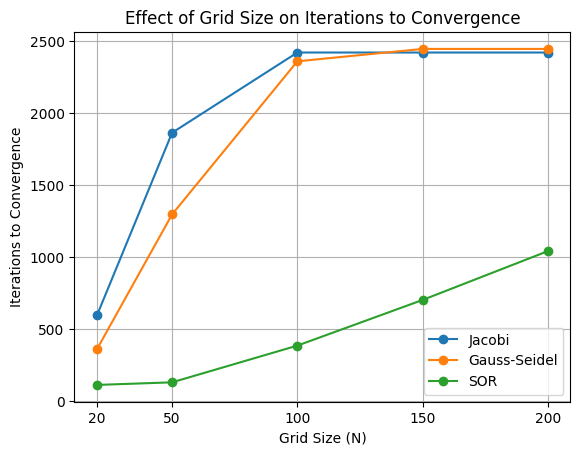

In [ ]:
N_values = [20, 50, 100, 150, 200]
omegas = np.arange(1.85,2.0,0.01)

jacobi_iterations = []
gauss_iterations = []
sor_iterations = []

for N in N_values:
    x_0 = np.zeros((N+1, N+1), dtype=float)
    x_0[:,-1] = 1
    _,_,jacobi_iters,_ = simulate_2D_diffusion_jacobi(x_0)
    _,_,gauss_iters,_ = simulate_2D_diffusion_gauss_seidel(x_0)
    _,_,sor_iters,_ = simulate_2D_diffusion_SOR(x_0, omega=1.92)

    jacobi_iterations.append(jacobi_iters)
    gauss_iterations.append(gauss_iters)
    sor_iterations.append(sor_iters)

plt.figure()
plt.plot(N_values, jacobi_iterations, marker='o', label='Jacobi')
plt.plot(N_values, gauss_iterations, marker='o', label='Gauss-Seidel')
plt.plot(N_values, sor_iterations, marker='o', label='SOR')

plt.xlabel('Grid Size (N)')
plt.ylabel('Iterations to Convergence')
plt.title('Effect of Grid Size on Iterations to Convergence')
plt.legend()
plt.grid(True)
plt.xticks(N_values)  # Ensure only the N values are marked on the x-axis
plt.show()

# Note that the time for every iteration drastically increases after 100 (obviously)
# - from few seconds per method to over a minute per method for convergence


Convergence reached at 135 iterations
Convergence reached at 129 iterations
Convergence reached at 123 iterations
Convergence reached at 117 iterations
Convergence reached at 112 iterations
Convergence reached at 110 iterations
Convergence reached at 112 iterations
Convergence reached at 120 iterations
Convergence reached at 133 iterations
Convergence reached at 155 iterations
Convergence reached at 168 iterations
Convergence reached at 180 iterations
Convergence reached at 197 iterations
Convergence reached at 227 iterations
Convergence reached at 271 iterations
Convergence reached at 320 iterations
Convergence reached at 394 iterations
Convergence reached at 532 iterations
Convergence reached at 793 iterations
Convergence reached at 298 iterations
Convergence reached at 287 iterations
Convergence reached at 276 iterations
Convergence reached at 265 iterations
Convergence reached at 253 iterations
Convergence reached at 241 iterations
Convergence reached at 229 iterations
Convergence 

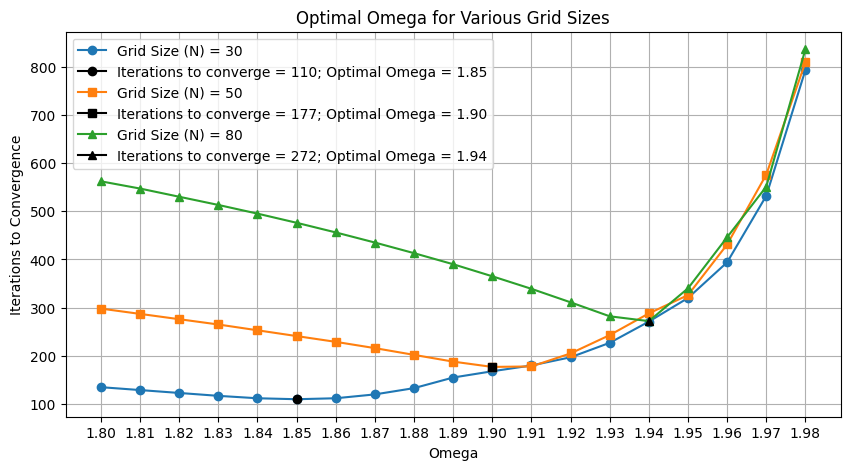

In [83]:
N_values = [30, 50, 80]
omegas = np.arange(1.80, 1.99, 0.01)

plt.figure(figsize=(10,5))
markers=['o','s','^']
for i,N in enumerate(N_values):
    sor_N_vs_om = []
    x_0 = np.zeros((N+1, N+1), dtype=float)
    x_0[:,-1] = 1

    for o in omegas:
        _, _, k,_ = simulate_2D_diffusion_SOR(x_0, omega=o)
        sor_N_vs_om.append(k)

    min_iterations = min(sor_N_vs_om)
    min_omega = omegas[sor_N_vs_om.index(min_iterations)]

    plt.plot(omegas, sor_N_vs_om, marker=markers[i], label=f'Grid Size (N) = {N}')
    plt.plot(min_omega, min_iterations, marker=markers[i], markersize=6,color='black', label=f'Iterations to converge = {min_iterations}; Optimal Omega = {min_omega:.2f}')

plt.xlabel('Omega')
plt.xticks(np.round(omegas, 2))  # Round for better tick readability
plt.ylabel('Iterations to Convergence')
plt.title('Optimal Omega for Various Grid Sizes')
plt.legend()
plt.grid(True)
plt.show()


#### K  

Implement the possibility to include objects into the computational domain. The objects should be sinks. Experiment a little bit with some objects in the computational domain (e.g. a rectangle or a few rectangles, ...). What is the influence on the number of iterations. What about the optimal ω , is it influenced by the presence of objects? Look at the resulting concentration fields, and try to interpret what happens. The implementation in this exercise will also be used for diffusion-limited aggregation in Set 2.

Hint: For the iterations, the presence of the objects is not complicated. If a point (i, j) is part of an object, the concentration is just 0, and an iteration is not necessary (i.e., the new value is also 0). Therefore, you must implement some easy encoding of the object in the computational grid, and during the iterations simply test if the grid point that you are updating is part of the object or not. If not, you apply the SOR rule, if yes, just put the new value to zero. The easiest encoding is just an extra array of integers, where e.g. a one-value would code for the presence of an object, and a zero value for the absence of an object.


In [ ]:
def in_sink(point, sinks):
    """
    Check if a given point is inside a sink.
    param point: The point to check.
    param sinks: A list of sinks, where each sink is a tuple with the format ['circle', x, y, r] or ['polygon', (x1 , y1),.., (xn, yn)].
    """
    for sink in sinks:
        if sink[0] == 'circle':
            if (point[0] - sink[1])**2 + (point[1] - sink[2])**2 <= sink[3]**2:
                return True
        if sink[0] == 'polygon':
            point = Point(point)
            polygon = Polygon(sink[1:])
            if polygon.contains(point):
                return True
    return False

In [ ]:
def simulate_2D_diffusion_SOR_with_sinks(x_0, dx, epsilon = 1e-5, omega=1.85, max_iter = 10000, save_iter_interval = 10, sinks=[]):
    """
    Simulate the 2D diffusion using the Successive Over Relaxation (SOR) method with a stopping condition.

    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    :param omega: The relaxation parameter for SOR.
    """
    c = init_concentration_matrix_2d(len(x_0), len(x_0))
    c[:,:] = x_0 # Initial condition at t=0

    print(sinks)
    
    saved_matrices = []
    saved_matrices.append(c.copy())

    sink_points = []

    for i in range(c.shape[0]):  # Skip the first and last rows which are boundary conditions
        for j in range(c.shape[1]):
            if in_sink((j*dx,i*dx), sinks):
                sink_points.append((i,j))

    for k in range(1, max_iter+1):
        c_old = c.copy()
        # Perform SOR iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end

                if (i,j) in sink_points:
                    c[i, j] = 0
                else:
                    # Update the concentration based on neighboring points with periodic boundaries
                    c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]
   
        if k % save_iter_interval == 0:  # Save every 10 iterations
            saved_matrices.append(c.copy())

        # Check for convergence
        delta = np.max(np.abs(c - c_old))
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break
    
    return saved_matrices, c, k

[['circle', 0.2, 0.8, 0.05], ['circle', 0.8, 0.8, 0.05], ['polygon', (0.4, 0.5), (0.6, 0.5), (0.5, 0.7)]]


Convergence reached at 164 iterations


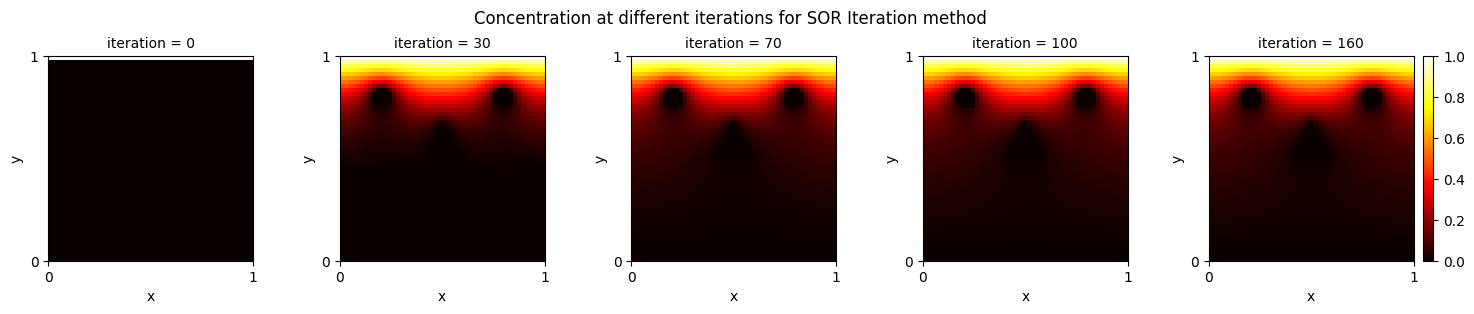

In [ ]:
sinks = [['circle', 0.2, 0.8, 0.05], ['circle', 0.8, 0.8, 0.05], ['polygon', (0.4, 0.5), (0.6, 0.5), (0.5, 0.7)]]
#sinks = [['polygon', (0.4, 0.5), (0.6, 0.5), (0.5, 0.7)]]['polygon', (0.1, 0.7), (0.2, 0.7), (0.15, 0.8)], 
dx = L/N
sor1, cs1, k = simulate_2D_diffusion_SOR_with_sinks(x_0, dx, omega=1.80, sinks=sinks)

figshape = (1, 5)
figsize = (15, 3)
iter_method = 'SOR'
iter_range = [0, 30, 70, 100, 160]
save_iter_interval = 10
plot_concentration_evolution(sor1, figshape, figsize, iter_method, iter_range, save_iter_interval)


#### Optional

Think of a way to incorporate objects with insulating material in your domain. What changes in the time evolution of the system? And in the final state?

In [ ]:
def simulate_2D_diffusion_with_sinks(D, L, T, dt, dx, x_0, sinks):
    """
    Simulate the 2D diffusion with the given parameters.
    param D: The diffusion coefficient.
    param L: The length of the domain.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.
    param x_0: The initial concentration.
    param sinks: A list of tuples, where each tuple contains two tuples. The first tuple contains the start and end indices of the x coordinate of the sink, and the diffusion constant D.    
    """
    if ((4 * dt * D) / (dx**2)) > 1:
        print((4 * dt * D) / (dx**2))
        raise ValueError("The given parameters will result in an unstable solution. Please use a smaller time step or a larger space step.")
    time_steps = np.arange(0, T+dt, dt)
    x = np.zeros((len(x_0), len(x_0), len(time_steps)), dtype=float) # Create an array to store the results.
    D = np.full((len(x_0), len(x_0)), D)
    for sink in sinks:
        D[sink[0][0]:sink[0][1], sink[1][0]:sink[1][1]] = sink[2]
    x[:,-1,:] = 1 # Set the boundary condition at y=L.
    x[:,0,:] = 0 # Set the boundary condition at y=0.
    x[:,:,0] = x_0 # Set the initial condition.
    # Assuming periodic boundary conditions at x=0 and x=L.
    for k in range(1, len(time_steps)):
        x[:, 1:-1, k] = x[:, 1:-1, k-1] + ((D[:,1:-1] * dt) / (dx**2)) * (np.roll(x[:, 1:-1, k-1],-1,axis=0) + np.roll(x[:, 1:-1, k-1],1,axis=0) + x[:, 2:, k-1] + x[:, 0:-2, k-1] - 4*x[:, 1:-1, k-1])
        # for sink in sinks:
        #     x[sink[0][0]:sink[0][1], sink[1][0]:sink[1][1], k] = 0

    return x


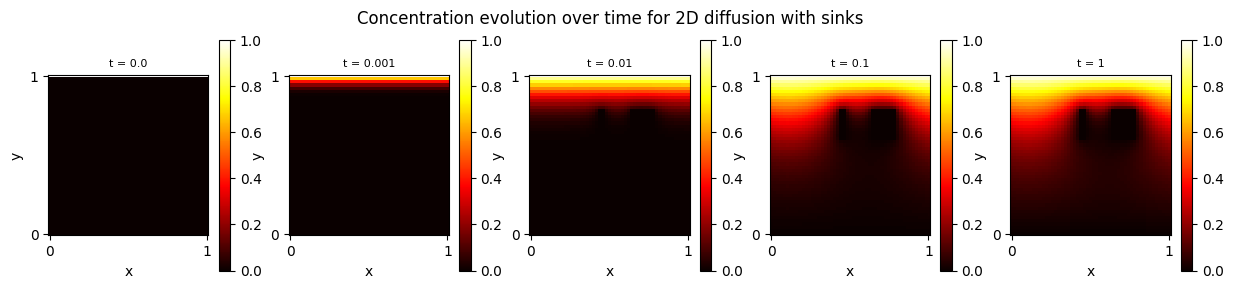

In [ ]:
# define the parameters
D = 1
L = 1
T = 1
# need to experiment with the time step and space step to get a stable solution.
dt = 0.0001
N = 50
dx = L/N
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:, -1] = 1
sinks = [((22,24),(30,40),0.4),((32,40),(30,40),0.8)]

x = simulate_2D_diffusion_with_sinks(D, L, T, dt, dx, x_0,sinks)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15, 3))
for i,t in enumerate([0.0, 0.001, 0.01, 0.1, 1]):
    im = ax[i].imshow(x[:,:,int(t/dt)].T, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=ax[i])
    #fig.colorbar(im, ax=ax[i], label='Concentration'
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, N], ['0', str(L)])
    ax[i].set_yticks([0, N], ['0', str(L)])
    ax[i].set_title('t = {}'.format(t), fontsize=8)

fig.suptitle('Concentration evolution over time for 2D diffusion with sinks', fontsize=12)
plt.show()
